## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
'''EarlyStopping參數'''
MONITOR = ["val_loss","val_accuracy"]
PATIENCE = [5, 10, 25]

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

results = {}
for i, (monitor, patience) in enumerate(itertools.product(MONITOR, PATIENCE)):
    earlystop = EarlyStopping(monitor=monitor, 
                              patience=patience, 
                              verbose=1)
    print("Numbers of exp: %i, monitor: %s, patience: %i" % (i, monitor, patience))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True,
              callbacks=[earlystop])
    
    # Collect results
    exp_name_tag = "monitor-%s, patience: %s" % (str(monitor),str(patience))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, monitor: val_loss, patience: 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_norma

49/49 [==============================] - 1s 27ms/step - loss: 0.7167 - accuracy: 0.7505 - val_loss: 1.8936 - val_accuracy: 0.4267
Epoch 19/50
49/49 [==============================] - 1s 28ms/step - loss: 0.6818 - accuracy: 0.7654 - val_loss: 2.1238 - val_accuracy: 0.3909
Epoch 00019: early stopping
Numbers of exp: 4, monitor: val_accuracy, patience: 10
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________________________________

Epoch 20/50
49/49 [==============================] - 1s 30ms/step - loss: 0.6539 - accuracy: 0.7729 - val_loss: 1.7948 - val_accuracy: 0.4505
Epoch 21/50
49/49 [==============================] - 1s 29ms/step - loss: 0.6253 - accuracy: 0.7830 - val_loss: 1.9111 - val_accuracy: 0.4430
Epoch 22/50
49/49 [==============================] - 1s 29ms/step - loss: 0.5961 - accuracy: 0.7937 - val_loss: 2.0736 - val_accuracy: 0.4201
Epoch 23/50
49/49 [==============================] - 1s 29ms/step - loss: 0.5525 - accuracy: 0.8100 - val_loss: 2.8016 - val_accuracy: 0.3603
Epoch 24/50
49/49 [==============================] - 1s 29ms/step - loss: 0.5213 - accuracy: 0.8198 - val_loss: 2.0698 - val_accuracy: 0.4567
Epoch 25/50
49/49 [==============================] - 1s 29ms/step - loss: 0.4910 - accuracy: 0.8330 - val_loss: 2.3293 - val_accuracy: 0.4046
Epoch 26/50
49/49 [==============================] - 1s 29ms/step - loss: 0.4735 - accuracy: 0.8380 - val_loss: 1.9832 - val_accuracy: 0.4648
Epoch 

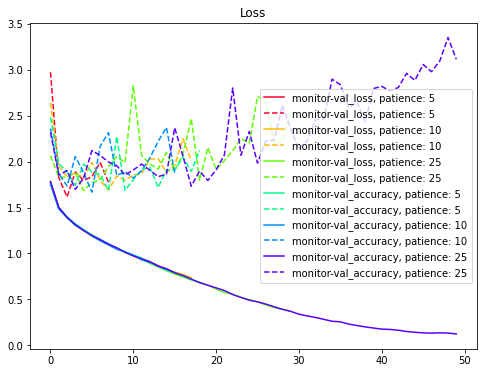

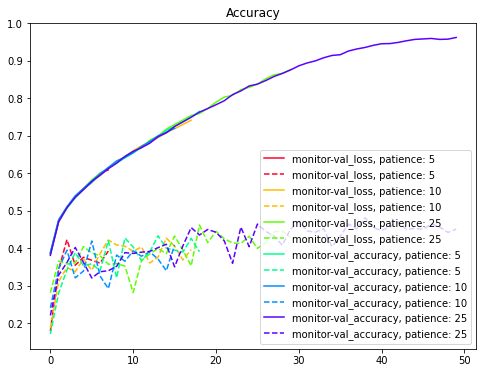

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
'''
以此例來說，當Earlystop的monitor設為val_accuracy，且patience設為25的時候準確率最高。
'''